# Data Post-processing

This notebook combines the subimages into image of original size. It uses X_train data to do the experiment and visualize some of the image to make sure the function works properly.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 

import numpy as np
import cv2
import glob
from math import ceil

In [2]:
def load_test():
    """This function takes in test.npy file which is generated in preprocessing.py by Raun
    The size of original np array is (221,100,image_size_x,image_size_y)
    It flatten the array into size (22100,image_size_x,image_size_y)"""
    file_num = len(glob.glob("X_train*.npy"))
    train_set = []
    for num in range(file_num):
        x_file_name = "X_train_" + str(num) + ".npy"
        x = np.load(x_file_name)
        for array in x:
            train_set.append(array)
    return train_set

In [3]:
def slice_test_image(image):
    """This function takes in a image with size (image_size_x,image_size_y)
    It slices the input image into small subimages with size (128*128)
    It also records the number of slices made and if there is overlapping.
    if the image size is not divisible by 128, the last row/col of images overlap with the images from previous row/col"""
    new_images = []
    shape = image.shape
    x = ceil(shape[0]/128.)
    y = ceil(shape[1]/128.)
    x_last = shape[0] % 128
    y_last = shape[1] % 128
    for i in range(x):
        for j in range(y):
            if i == x-1:
                image_x = image[shape[0]-128:,:]
            else:
                image_x = image[(i)*128:(i+1)*128,:]
            if j == y-1:
                new_image = image_x[:,shape[1]-128:]
            else:
                new_image = image_x[:,(j)*128:(j+1)*128]
            new_images.append(new_image)
    return new_images,[x,y,x_last,y_last]

In [4]:
def preprocess(train_set):
    """This function create set of sliced images and masks"""
    subimage_set = []
    size_set = []
    size = len(train_set)
    for i in range(size):
        if i % 5000 == 0:
            print("finished slicing ", i, "images")
        image = train_set[i]
        images,image_shape = slice_test_image(image)
        for i in images:
            subimage_set.append(i)
        size_set.append(image_shape)
        
    return np.array(subimage_set),size_set

In [5]:
test_set = load_test()

In [6]:
new_test = []
for test in test_set:
    if test.shape == (240,320):
        new_test.append(test)

In [7]:
x_test,image_shapes = preprocess(test_set)

finished slicing  0 images
finished slicing  5000 images
finished slicing  10000 images
finished slicing  15000 images
finished slicing  20000 images


In [8]:
test_set[9000][-96:,:].shape

(96, 640)

In [9]:
def combine_predictions(prediction,image_shapes):
    """This function takes in the prediction generated by unet.
        Input shape (num_of_subimage,image_size_x,image_size_y)
        Output is a set of images which are combined from subimages according to the original size """
    image_index = 0
    image_set = []
    for shape in image_shapes:        
        x,y,x_last,y_last = shape[0],shape[1],shape[2],shape[3]
        for i in range(x):
            image_x = prediction[image_index]
            for j in range(y):
                if image_index < len(prediction) and j!=0:
                    if i == x-1 and x_last != 0:
                        image_x = image_x[-x_last:,:] 
                        if j == y-1 and y_last != 0:
                            image_x = np.concatenate((image_x,prediction[image_index][-x_last:,-y_last:]),axis=1)
                        else:
                            image_x = np.concatenate((image_x,prediction[image_index][-x_last:,:]),axis=1)
                    elif j == y-1 and y_last != 0 and i!=x-1:
                        image_x = np.concatenate((image_x,prediction[image_index][:,-y_last:]),axis=1)                        
                    else:
                        image_x = np.concatenate((image_x,prediction[image_index]),axis=1)
                image_index += 1
            if i == 0:
                image = image_x
            else:
                image = np.concatenate((image,image_x),axis = 0)
        image_set.append(image)
    return np.array(image_set)

In [10]:
prediction = x_test
out = combine_predictions(prediction,image_shapes)

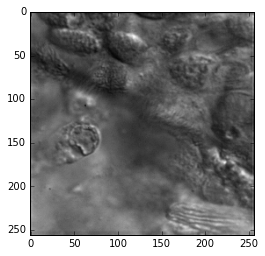

In [11]:
plt.imshow(out[0],"gray")

In [15]:
out.shape

(21100,)

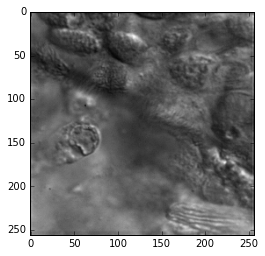

In [14]:
plt.imshow(test_set[0],"gray")